# Image Warping

Pointwise image operations change the colors and tones in images but the image content stays at the same location in the image.

Image warping is in some ways the opposite: the colors in the image stay the same, but the goal is to move them from place to place in the image.  How things move in the image is specified by a function from the domain of the output image to the domain of the input image.  Let’s call it \\(\phi\\).  If we think of the image \\(I\\) as a function \\(R^2 \rightarrow C\\) (where \\(C\\) is the set of colors, probably RGB triples but could be grayscale or include alpha or whatever it needs to), then the idea of image warping is that the output is a composition:

\\[O = I \circ \phi\\]

That is, to evaluate the output image at a particular point \\(\mathbf{x}\\), you simply evaluate the input image at the point \\(\phi(\mathbf{x})\\).

So to compute the value of a pixel in \\(O\\), we compute the point in the domain of \\(I\\) that corresponds, and we look up the value of \\(I\\) there.  Since \\(I\\) is represented as a grid of pixels, and there is no particular reason that the desired sample locations are aligned with pixel locations, this is going to require interpolation.

In [1]:
import math
import numpy as np
from PIL import Image
from IPython.display import display
from ipywidgets import interact

In [2]:
%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

Let's start by loading an image that has some detail and sharp edges in it, which will help reveal differences between interpolation methods.

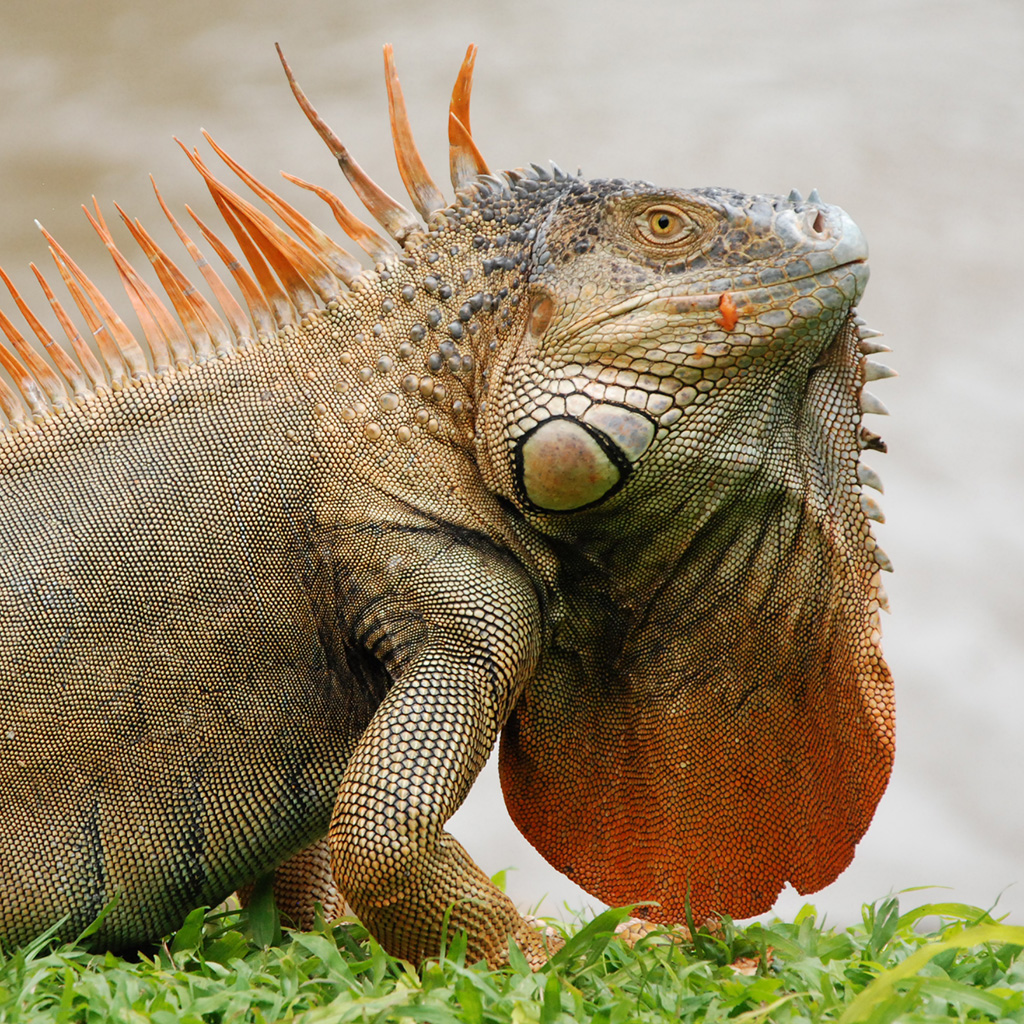

In [3]:
im = np.array(Image.open('inputs/iguana.jpg'))
display(Image.fromarray(im))


As a warm-up, write a function that takes an image and returns that image shifted to the left by k pixels.  Observe that to do this means looking k pixels to the *right* in the input image.  This is exactly the same phenomenon as the function \\(f(x+3)\\) looking like \\(f(x)\\) shifted 3 units to the *left*, even though \\(x+3\\) is to the right of \\(x\\). 


Image is same as reference:  True


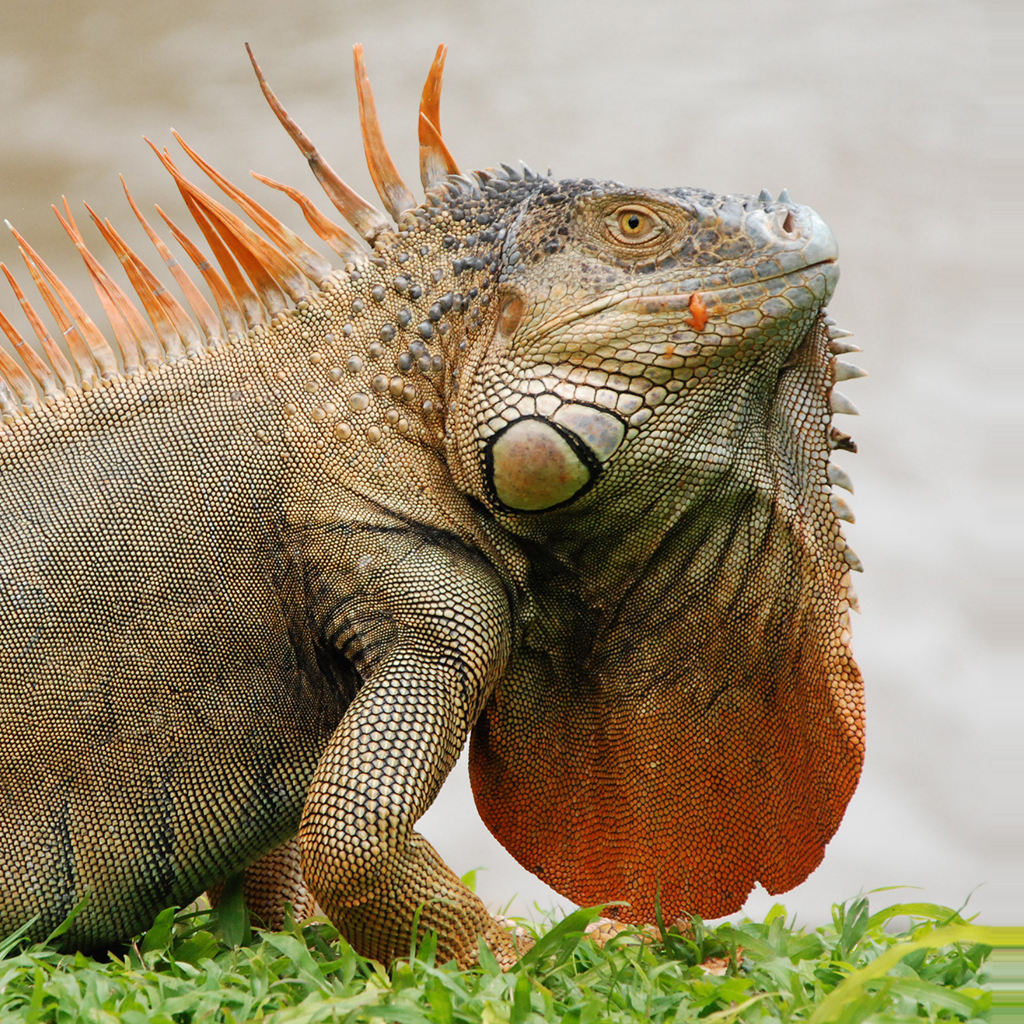

In [29]:
# ======================= shift_image_to_left =======================
# Input:
#   img: 2D numpy array of a grayscale image
#   k: The number of units/pixels to be shifted to the left (you can assume k < width of image)
# Output:
#   A 2D array of img shifted to the left by k pixels
#   For points that fall out of range on the right side, repeat the rightmost pixel. 
def shift_image_to_left(img, k):
    new_img = np.zeros(img.shape, np.uint8)
    length = img.shape[1]
    height = img.shape[0]
    
    for i in range(0, height):
        for j in range(0, length):
            if (j+k < length):
                new_img[i][j] = img[i][j+k]
            else:
                new_img[i][j] = img[i][length-1]

    return new_img

# This is for testing
ref_shift_im = np.array(Image.open('./reference/distortion-shift-reference.png'))
shift_im = shift_image_to_left(im, 30)

print("Image is same as reference: ", np.array_equal(ref_shift_im[:,:-30,:], shift_im[:,:-30,:]))
display(Image.fromarray(shift_im))


## Rotating images

Next write a function to rotate an image by k degrees counter-clockwise around its center.  What function \\(\phi\\) do you need to accomplish this? For points that fall outside the bounds of the input image, you can just put in black.

This rotation is done around the center of the image. This should be an integer coordinate value. Calculate the center by using python integer division (this will handle odd length and widths). 

**For now ignore the `interp_mode` parameter and use nearest-neighbor interpolation when looking up values from the input image. This corresponds to interp_mode = 0. You will come back to this and implement interp_mode=1 for bilinear interpolation later in the assignment**

Image is same as reference:  False


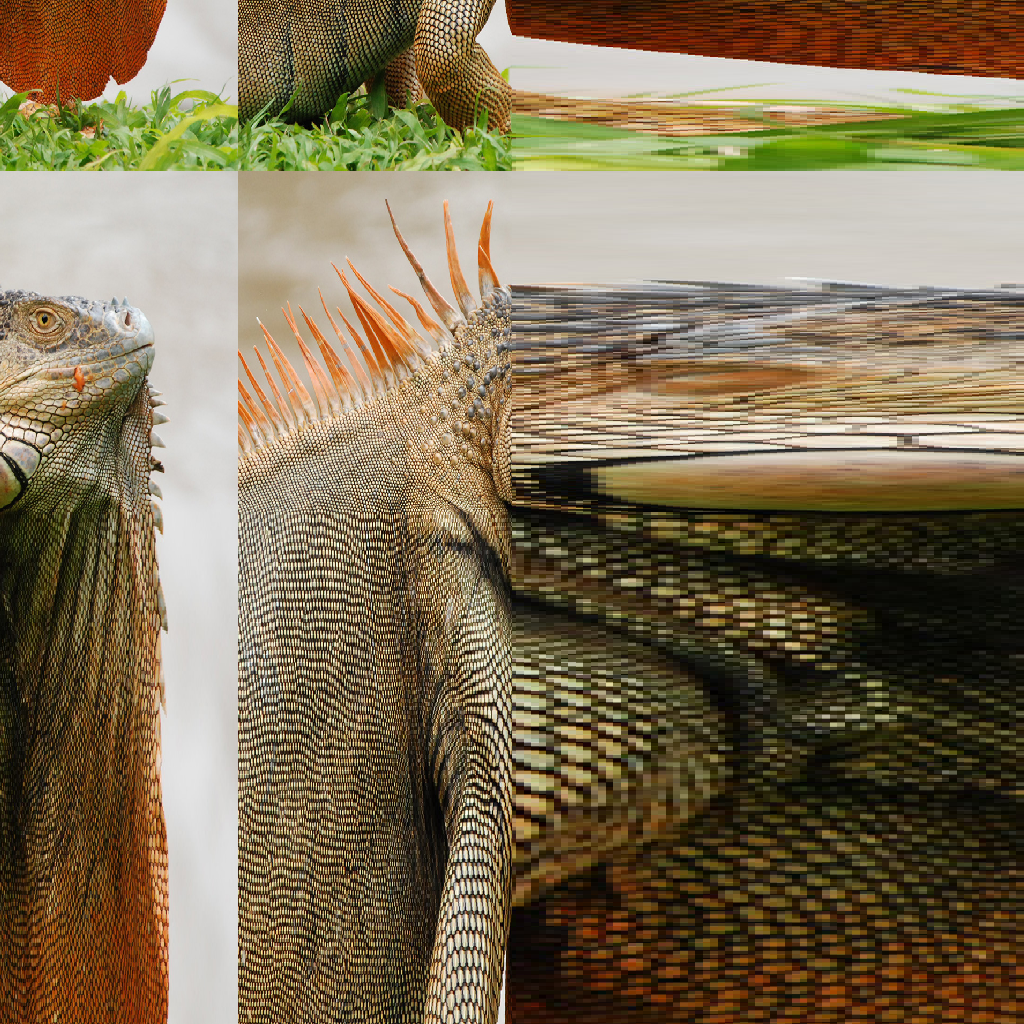

CPU times: user 9.41 s, sys: 128 ms, total: 9.54 s
Wall time: 9.81 s


In [37]:
%%time
# ======================= rotate_image =======================
# Input:
#   img: 2D numpy array of a grayscale image
#   k: The angle (in degrees) to be rotated counter-clockwise around the image center
#   interp_mode: 0 for nearest neighbor, 1 for bilinear
# Output:
#   A 2D array of img rotated around the original image's center by k degrees
# Put black in for points that fall out of bounds
def rotate_image(img, k, interp_mode=0):
    new_img = np.zeros(img.shape, np.uint8)
    # A3TODO: Complete this function
    center_x = img.shape[1] // 2
    center_y = img.shape[0] // 2
    
    length = img.shape[1]
    height = img.shape[0]
    rad = np.radians(k)
    
    for i in range(0, height):
        for j in range(0, length):
            row = round(i-np.sin(rad)*(abs(i-center_x)))
            col = round(j-np.cos(rad)*(abs(j-center_y)))
            if (row < length and col < height):
                new_img[i][j] = img[row][col]

    
    return new_img 

# This is for testing
rot_im = rotate_image(im, 30)
ref_rot_im = np.array(Image.open('./reference/distortion-rotate-reference.png'))

print("Image is same as reference: ", np.array_equal(ref_rot_im, rot_im))
display(Image.fromarray(rot_im))

A fun stress test for image rotation is to apply the operation many times so that the image rotates a full 360 degrees.  Try it below; you might like to set `k` to a smaller value if your implementation is slow.  With nearest-neighbor sampling this test will produce artifacts that look like noise around details and edges.

In [ ]:
%%time
k = 20
rot_360 = im
for i in range(k):
    rot_360 = rotate_image(rot_360, 360/k)

display(Image.fromarray(rot_360))

## Correcting lens distortion

Below we load a camera image that is very wide-angle and has a lot of distortion (the straight lines in the scene do not stay straight in the image).  This is a common behavior of wide angle camera optics, but we might like to have an image that does not exhibit this distortion.  Fortunately the distortion that is caused by lenses can often be described by simple models, which lets us use image warping to correct for it.

By analyzing a set of photos of a known pattern (a checkerboard) we have fit such a model for this particular camera.  This model is a function that maps the point where an ideal lens would put a particular image feature to the place where our distorted lens actually puts it.  This is the right kind of function \\(\phi\\) for an image warp, since we can give it the coordinates of a pixel in the corrected image we want, and it will tell us where we should look for the content in the distorted image we have.

This particular model compes in two parts: a polynomial model for radial distortion, and an affine transformation from pixel coordinates to the coordinates where the distortion model is defined.

The distortion model (denote it as $g$) is called a radial distortion model because it moves each point along the line from the origin to that point.  It is written as a scaling of the input point where the scaling depends on the distance from the origin: a point \\(x\\) which has distance \\(r = \|\mathbf{x}\|\\) from the origin maps to the point \\(s\mathbf{x}\\) where \\(s\\) is a scale factor that depends on \\(r\\):

\\[
g(\mathbf{x}) = s(r) \mathbf{x}\\
s(r) = 1 + k_1 r^2 + k_2 r^4
\\]

The two coefficients \\(k_1\\) and \\(k_2\\) describe the kind of distortion.  For instance, if both are zero, the scale factor is always 1 and there is no distortion.

The other piece of the calibration data is a 2D affine transformation (denote it as matrix $A$) that relates the pixel coordinates (where (0,0) is at the corner, not an appropriate center for lens distortion) to the coordinates of this distortion model.  In particular, this transformation takes the distortion-model coordinates and maps to image coordinates:

\\[
\mathbf{x}_\mathrm{pix} = A \mathbf{x}
\\]

where \\(\mathbf{x}_\mathrm{pix}\\) is the coordinates of the point measured in pixels.  For example, the center of distortion, measured in pixels, is the translation part of this matrix.  Putting it all together, what is the distortion model $\phi(\mathbf{x})$ that transforms a distorted image into an undistorted image (written in terms of $M$ and $g$ where M is the inverse of A)? The input is a coordinate in image space for the distorted image and the output is coordinates in image space of the undistorted pixel that should be stored where the original distorted pixel was. 

[We leave it as an exercise.]

Write a function that will compute the undistorted image given the distorted image and the model parameters.  Try it on the provided example and see if it straightens out the lines!

In [ ]:
distorted_im = np.array(Image.open('inputs/room.jpg'))
display(Image.fromarray(distorted_im))

Here are the distortion model parameters for the camera that took this image:

In [ ]:
M = np.array([ 
    [5.7871056857319593e+02, 0., 5.4526824062989147e+02],
    [0., 5.7871056857319593e+02, 3.8199592334118745e+02],
    [0., 0., 1. ]
])
k1, k2 = -2.6411937522059986e-01, 6.2966059838308094e-02

**Like with rotate_image, ignore the interp_mode parameter for now and use nearest-neighbor interpolation. This corresponds to interp_mode = 0. You will come back to this and implement interp_mode=1 for bilinear interpolation later in the assignment**

In [ ]:
# ======================= undistort_image =======================
# Input:
#   img: A distorted image, with coordinates in the distorted space
#   k1, k2: distortion model coefficients (see explanation above)
#   M: affine transformation from pixel coordinates to distortion-model coordinates (note that this is different from the matrix A in the description)
#   interp_mode: 0 for nearest neighbor, 1 for bilinear
# Output:
#   An undistorted image, with pixels in the image coordinates
# Write down the formula for calculating the distortion model first (see exercise above)
# Put black in for points that fall out of bounds
def undistort_image(img, k1, k2, M, interp_mode=0):
    Mi = np.linalg.inv(M)
    output = np.zeros_like(img)
    # A3TODO: Complete this function

    return output

In [ ]:
%%time
undistort_im = undistort_image(distorted_im, k1, k2, M)
ref_undistort_im = np.array(Image.open('./reference/distortion-img-reference.png'))

print("Image is same as reference: ", np.array_equal(ref_undistort_im, undistort_im))
display(Image.fromarray(undistort_im))


## Bilinear interpolation

So far we have just rounded off coordinates when looking up points in the input image.  But this produces some artifacts, in the form of jagged edges where things used to look smooth.  The edges of the door and doorframe in the distortion example show this pretty strongly.  To see a dramatic illustration try rotating your image by 18 degrees 20 times; it ought to be back to the same image, but you will see it has been damaged quite a bit.  This damage is unavoidable, but it can be made less objectionable by more careful interpolation.

Check out the image interpolation lecture to learn about better methods for interpolation in images.

**Note that the function signatures for the rotation and undistortion functions have an argument that lets you request bilinear interpolation. 
Go back and add that branch now; compute the sample points in the input image in exactly the same way, but then rather than rounding to the nearest integer coordinate, look up the four neighboring pixels and average them with bilinear interpolation weights. This corresponds to the interp_mode paramater being 1.**

Here are some cells to compare the timings and results of the image distortion operation with the two interpolation modes.

In [ ]:
%%time
undistort_im_nn = undistort_image(distorted_im, k1, k2, M, 0)

In [ ]:
%%time
undistort_im_lin = undistort_image(distorted_im, k1, k2, M, 1)

In [ ]:
ref_undistort_im_lin = np.array(Image.open('./reference/distortion-img-lin-reference.png'))
print("Image is same as reference: ", np.array_equal(ref_undistort_im_lin, undistort_im_lin))

interact(
    lambda mode: display(Image.fromarray(undistort_im_lin if mode == 1 else undistort_im_nn)),
    mode=[('nearest neighbor', 0), ('bilinear interpolation', 1)]
)

Here are some cells to compare the timings and results of the image rotation operation under the two modes.  You should see much less jaggedness on the edges of the iguana's spines with linear interpolation.  You might need to zoom in in your browser a bit to really notice the change.

In [ ]:
%%time
rotated_im_nn = rotate_image(im, 30, 0)

In [ ]:
%%time
rotated_im_lin = rotate_image(im, 30, 1)

In [ ]:
ref_rotated_im_lin = np.array(Image.open('./reference/rotated-img-lin-reference.png'))
print("Image is same as reference: ", np.array_equal(ref_rotated_im_lin, rotated_im_lin))

interact(
    lambda mode: display(Image.fromarray(rotated_im_lin if mode == 1 else rotated_im_nn)),
    mode=[('nearest neighbor', 0), ('bilinear interpolation', 1)]
)

If we re-do the rotation experiment in bilinear interpolation mode, the result is much cleaner.  Still a bit blurry after 20 steps of resampling, but not covered with strange noisy artifacts.

In [ ]:
%%time
k = 20
rot_360 = im
for i in range(k):
    rot_360 = rotate_image(rot_360, 360/k, 1)

display(Image.fromarray(rot_360))